## Setup Everything

In [1]:
# @title Setup Everything

!nvidia-smi
!git clone https://github.com/hongfz16/EVA3D.git
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])
!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
!pip install -r EVA3D/requirements.txt

Mon May  1 19:08:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Connect Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Models

In [3]:
# @title Download Models
%cd EVA3D
from download_models import download_pretrained_models
download_pretrained_models()

/content/EVA3D


100%|██████████| 160M/160M [00:04<00:00, 32.6MB/s]


100%|██████████| 160M/160M [00:02<00:00, 54.8MB/s]


100%|██████████| 160M/160M [00:02<00:00, 58.6MB/s]


100%|██████████| 158M/158M [00:03<00:00, 44.0MB/s]


Register and download SMPL models here. Put the downloaded models in the folder smpl_models. Only the neutral one is needed. The folder structure should look like


```
./
├── ...
└── smpl_models/
    ├── smpl/
        └── SMPL_NEUTRAL.pkl
```



## import library

In [4]:
import os
import torch
import trimesh
import imageio
import pickle
import numpy as np
from munch import *
from PIL import Image
from tqdm import tqdm
from torch.nn import functional as F
from torch.utils import data
from torchvision import utils
from torchvision import transforms
from skimage.measure import marching_cubes
from scipy.spatial import Delaunay
from scipy.spatial.transform import Rotation as R
from options import BaseOptions
from model import VoxelHumanGenerator as Generator
from dataset import DeepFashionDataset, DemoDataset
from utils import (
    generate_camera_params,
    align_volume,
    extract_mesh_with_marching_cubes,
    xyz2mesh,
    requires_grad,
    create_mesh_renderer,
    create_cameras
)
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
)

torch.random.manual_seed(8888)
import random
random.seed(8888)

panning_angle = np.pi / 3


## Functions

In [5]:
def sample_latent(opt, device):
    return 

def generate_rgb(opt, g_ema, device, mean_latent, sample_z, sample_trans, sample_beta, sample_theta, sample_cam_extrinsics, sample_focals):
    requires_grad(g_ema, False)
    g_ema.is_train = False
    g_ema.train_renderer = False
    img_list = []
    for k in range(3):
        if k == 0:
            delta = R.from_rotvec(np.pi/8 * np.array([0, 1, 0]))
        elif k == 2:
            delta = R.from_rotvec(-np.pi/8 * np.array([0, 1, 0]))
        else:
            delta = R.from_rotvec(0 * np.array([0, 1, 0]))
        r = R.from_rotvec(sample_theta[0, :3].cpu().numpy())
        new_r = delta * r
        new_sample_theta = sample_theta.clone()
        new_sample_theta[0, :3] = torch.from_numpy(new_r.as_rotvec()).to(device)

        with torch.no_grad():
            j = 0
            chunk = 1
            out = g_ema([sample_z[j:j+chunk]],
                        sample_cam_extrinsics[j:j+chunk],
                        sample_focals[j:j+chunk],
                        sample_beta[j:j+chunk],
                        new_sample_theta[j:j+chunk],
                        sample_trans[j:j+chunk],
                        truncation=opt.truncation_ratio,
                        truncation_latent=mean_latent,
                        return_eikonal=False,
                        return_normal=False,
                        return_mask=False,
                        fix_viewdir=True)

        rgb_images_thumbs = out[1].detach().cpu()[..., :3].permute(0, 3, 1, 2)
        g_ema.zero_grad()
        img_list.append(rgb_images_thumbs)

        utils.save_image(torch.cat(img_list, 0),
                        os.path.join(opt.results_dst_dir, 'images_paper_fig','{}.png'.format(str(0).zfill(7))),
                        nrow=3,
                        normalize=True,
                        range=(-1, 1),
                        padding=0,)

def generate_mesh(opt, g_ema, device, mean_latent, sample_z, sample_trans, sample_beta, sample_theta, sample_cam_extrinsics, sample_focals):
    latent = g_ema.styles_and_noise_forward(sample_z[:1], None, opt.truncation_ratio,
                                            mean_latent, False)

    sdf = g_ema.renderer.marching_cube_posed(latent[0], sample_beta, sample_theta, resolution=350, size=1.4).detach()
    marching_cubes_mesh, _, _ = extract_mesh_with_marching_cubes(sdf, level_set=0)
    marching_cubes_mesh = trimesh.smoothing.filter_humphrey(marching_cubes_mesh, beta=0.2, iterations=5)
    # marching_cubes_mesh_filename = os.path.join(opt.results_dst_dir,'marching_cubes_meshes_posed','sample_{}_marching_cubes_mesh.obj'.format(0))
    # with open(marching_cubes_mesh_filename, 'w') as f:
    #     marching_cubes_mesh.export(f,file_type='obj')
    return marching_cubes_mesh

def generate_video(opt, g_ema, device, mean_latent, sample_z, sample_trans, sample_beta, sample_theta, sample_cam_extrinsics, sample_focals):
    video_list = []
    for k in tqdm(range(120)):
        if k < 30:
            angle = (panning_angle / 2) * (k / 30)
        elif k >= 30 and k < 90:
            angle = panning_angle / 2 - panning_angle * ((k - 30) / 60)
        else:
            angle = -panning_angle / 2 * ((120 - k) / 30)
        delta = R.from_rotvec(angle * np.array([0, 1, 0]))
        r = R.from_rotvec(sample_theta[0, :3].cpu().numpy())
        new_r = delta * r
        new_sample_theta = sample_theta.clone()
        new_sample_theta[0, :3] = torch.from_numpy(new_r.as_rotvec()).to(device)
        with torch.no_grad():
            j = 0
            chunk = 1
            out = g_ema([sample_z[j:j+chunk]],
                        sample_cam_extrinsics[j:j+chunk],
                        sample_focals[j:j+chunk],
                        sample_beta[j:j+chunk],
                        new_sample_theta[j:j+chunk],
                        sample_trans[j:j+chunk],
                        truncation=opt.truncation_ratio,
                        truncation_latent=mean_latent,
                        return_eikonal=False,
                        return_normal=False,
                        return_mask=False,
                        fix_viewdir=True)
        rgb_images_thumbs = out[1].detach().cpu()[..., :3]
        g_ema.zero_grad()
        video_list.append((rgb_images_thumbs.numpy() + 1) / 2. * 255. + 0.5)
    all_img = np.concatenate(video_list, 0).astype(np.uint8)
    imageio.mimwrite(os.path.join(opt.results_dst_dir, 'images_paper_video', 'video_{}.mp4'.format(str(0).zfill(7))), all_img, fps=30, quality=8)

def setup():
    device='cuda' if torch.cuda.is_available() else 'cpu'
    opt = BaseOptions().parse()

    opt.training.batch = 1
    opt.training.chunk = 1
    opt.experiment.expname = '512x256_deepfashion'
    opt.dataset.dataset_path = 'demodataset'
    opt.rendering.depth = 5
    opt.rendering.width = 128
    opt.model.style_dim = 128
    opt.model.renderer_spatial_output_dim = [512, 256]
    opt.training.no_sphere_init = True
    opt.rendering.input_ch_views = 3
    opt.rendering.white_bg = True
    opt.model.voxhuman_name = 'eva3d_deepfashion'
    opt.training.deltasdf = True
    opt.rendering.N_samples = 28
    opt.experiment.ckpt = '420000'
    opt.inference.identities = 1
    opt.inference.truncation_ratio = 0.6

    opt.model.is_test = True
    opt.model.freeze_renderer = False
    opt.rendering.no_features_output = True
    opt.rendering.offset_sampling = True
    opt.rendering.static_viewdirs = True
    opt.rendering.force_background = True
    opt.rendering.perturb = 0
    opt.inference.size = opt.model.size
    opt.inference.camera = opt.camera
    opt.inference.renderer_output_size = opt.model.renderer_spatial_output_dim
    opt.inference.style_dim = opt.model.style_dim
    opt.inference.project_noise = opt.model.project_noise
    opt.inference.return_xyz = opt.rendering.return_xyz
    
    checkpoints_dir = os.path.join('checkpoint', opt.experiment.expname, 'volume_renderer')
    checkpoint_path = os.path.join(checkpoints_dir,
                                    'models_{}.pt'.format(opt.experiment.ckpt.zfill(7)))
    # define results directory name
    result_model_dir = 'iter_{}'.format(opt.experiment.ckpt.zfill(7))

    # create results directory
    results_dir_basename = os.path.join(opt.inference.results_dir, opt.experiment.expname)
    opt.inference.results_dst_dir = os.path.join(results_dir_basename, result_model_dir)
    if opt.inference.fixed_camera_angles:
        opt.inference.results_dst_dir = os.path.join(opt.inference.results_dst_dir, 'fixed_angles')
    else:
        opt.inference.results_dst_dir = os.path.join(opt.inference.results_dst_dir, 'random_angles')
    os.makedirs(opt.inference.results_dst_dir, exist_ok=True)
    os.makedirs(os.path.join(opt.inference.results_dst_dir, 'images_paper_fig'), exist_ok=True)
    os.makedirs(os.path.join(opt.inference.results_dst_dir, 'images_paper_video'), exist_ok=True)
    os.makedirs(os.path.join(opt.inference.results_dst_dir, 'marching_cubes_meshes_posed'), exist_ok=True)
    checkpoint = torch.load(checkpoint_path, map_location=lambda storage, loc: storage)

    # load generation model
    g_ema = Generator(opt.model, opt.rendering, full_pipeline=False, voxhuman_name=opt.model.voxhuman_name).to(device)
    pretrained_weights_dict = checkpoint["g_ema"]
    model_dict = g_ema.state_dict()
    for k, v in pretrained_weights_dict.items():
        if v.size() == model_dict[k].size():
            model_dict[k] = v
        else:
            print(k)

    g_ema.load_state_dict(model_dict)

    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True)])
    
    if 'deepfashion' in opt.dataset.dataset_path:
        file_list = '/mnt/lustre/fzhong/smplify-x/deepfashion_train_list/deepfashion_train_list_MAN.txt'
    elif '20w_fashion' in opt.dataset.dataset_path:
        file_list = '/mnt/lustre/fzhong/mmhuman3d/20w_fashion_result/nondress_flist.txt'
    else:
        file_list = None
    if file_list:
        dataset = DeepFashionDataset(opt.dataset.dataset_path, transform, opt.model.size,
                                     opt.model.renderer_spatial_output_dim, file_list)
    else:
        dataset = DemoDataset()

    # get the mean latent vector for g_ema
    if opt.inference.truncation_ratio < 1:
        with torch.no_grad():
            mean_latent = g_ema.mean_latent(opt.inference.truncation_mean, device)
    else:
        mean_latent = None

    g_ema.renderer.is_train = False
    g_ema.renderer.perturb = 0

    # generate(opt.inference, dataset, g_ema, device, mean_latent, opt.rendering.render_video)

    sample_trans, sample_beta, sample_theta = dataset.sample_smpl_param(1, device, val=False)
    sample_cam_extrinsics, sample_focals = dataset.get_camera_extrinsics(1, device, val=False)

    torch.randn(1, opt.inference.style_dim, device=device)

    return opt.inference, g_ema, device, mean_latent, torch.randn(1, opt.inference.style_dim, device=device), \
           sample_trans, sample_beta, sample_theta, sample_cam_extrinsics, sample_focals


In [6]:
import plotly.graph_objects as go
from PIL import Image

setup_list = None

def get_video():
    global setup_list
    if setup_list is None:
        setup_list = list(setup())
    generate_video(*setup_list)
    torch.cuda.empty_cache()
    path = 'evaluations/512x256_deepfashion/iter_0420000/random_angles/images_paper_video/video_0000000.mp4'
    return path

def get_mesh():
    global setup_list
    if setup_list is None:
        setup_list = list(setup())
    setup_list[4] = torch.randn(1, setup_list[0].style_dim, device=setup_list[2])
    generate_rgb(*setup_list)
    mesh = generate_mesh(*setup_list)
    torch.cuda.empty_cache()

    x=np.asarray(mesh.vertices).T[0]
    y=np.asarray(mesh.vertices).T[1]
    z=np.asarray(mesh.vertices).T[2]

    i=np.asarray(mesh.faces).T[0]
    j=np.asarray(mesh.faces).T[1]
    k=np.asarray(mesh.faces).T[2]
    fig = go.Figure(go.Mesh3d(x=x, y=y, z=z, 
                    i=i, j=j, k=k, 
                    color="lightpink",
                    # flatshading=True,
                    lighting=dict(ambient=0.5,
                                    diffuse=1,
                                    fresnel=4,        
                                    specular=0.5,
                                    roughness=0.05,
                                    facenormalsepsilon=0,
                                    vertexnormalsepsilon=0),))
                    # lightposition=dict(x=100,
                    #                     y=100,
                    #                     z=1000)))
    path='evaluations/512x256_deepfashion/iter_0420000/random_angles/images_paper_fig/0000000.png'

    image=Image.open(path)

    return fig,image

In [49]:
fig, img = get_mesh()

Marching Cube: 0/2
Marching Cube: 1/2


In [58]:
fig

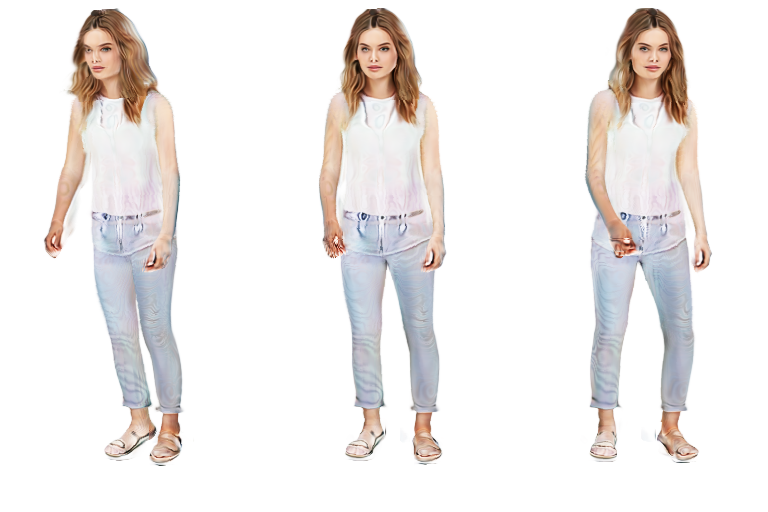

In [59]:
img